# **Dependencies**

In [1]:
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import cv2
import os

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#!unzip /content/FER_2013_80-20_Dataset.zip
!unzip /content/FER-2013-Full.zip

# **Test Read Image**

Original Data: https://www.kaggle.com/datasets/msambare/fer2013/data

In [ ]:
# img_array = cv2.imread("/content/FER2013Dataset/train/surprise/Training_72717626.jpg")
img_array = cv2.imread("/content/train/surprise/Training_72717626.jpg")
img_array.shape

(48, 48, 3)

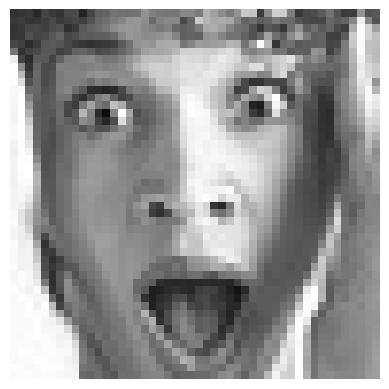

In [ ]:
plt.axis('off')
plt.imshow(img_array)

# **Data**

**Original Train**: [angry: 3995, disgust: 436, fear: 4097, happy: 7215, neutral: 4965, sad: 4830, surprise: 3171]

**Modified Train**: [anger: 2000, disgust: 436, fear: 2000, happy: 2000, neutral: 2000, sad: 2000, surprise: 2000]

**Original Test**: [angry: 958, disgust: 111, fear: 1024, happy: 1774, neutral: 1233, sad: 1247, surprise: 831]

**Modified Test**: [anger: 500, disgust: 111, fear: 500, happy: 500, neutral: 500, sad: 500, surprise: 500]

In [2]:
Classes = ['angry','disgust','fear','happy','neutral','sad','surprise']
# Classes = ['happy', 'sad']
# Classes = ['happy', 'sad', 'neutral']
# Classes = ['happy', 'sad', 'angry']
# Classes = ['surprise', 'fear', 'disgust']
# Classes = ['sad', 'fear', 'angry']
# Classes = ['happy', 'sad', 'neutral', 'angry']

## **Read all images, resize, and convert into arrays**

In [3]:
def create_data( data, Datadirectory ):
  for category in Classes:
    path = os.path.join(Datadirectory, category)
    class_num = Classes.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img) )
        #img_array = cv2.resize(img_array, (48, 48) )
        data.append( [img_array, class_num] )
      except Exception as e:
        pass

In [4]:
training_data = []
# Datadirectory = "/content/FER2013Dataset/train"
Datadirectory = "/content/train"
create_data(training_data, Datadirectory)

In [5]:
testing_data = []
# Datadirectory = "/content/FER2013Dataset/test"
Datadirectory = "/content/test"
create_data(testing_data, Datadirectory)

In [6]:
print( len(training_data) )
print( len(testing_data) )

28709
7178


## **Create Training and Testing Data Arrays**

In [7]:
def create_train_test(data, x, y):
  for features, label in data:
    x.append(features)
    y.append(label)

In [8]:
x_train = []
y_train = []

x_test = []
y_test = []

create_train_test(training_data, x_train, y_train)
create_train_test(testing_data, x_test, y_test)

In [9]:
X_train = np.array(x_train).reshape(-1, 48, 48, 3)
Y_train = np.array(y_train)

X_test = np.array(x_test).reshape(-1, 48, 48, 3)
Y_test = np.array(y_test)

###**Regular Data Processing**

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0



```
# This is formatted as code
```

###**Data Augmentation on the Fly**

In [52]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the generator to augment data on-the-fly
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

###**Targeted Data Augmentation**

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

original_x_train, x_val, original_y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Convert validation set to numpy arrays and normalize
X_val = np.array(x_val).reshape(-1, 48, 48, 3) / 255.0
Y_val = np.array(y_val)

training_data_for_aug = list(zip(original_x_train, original_y_train))

datagen_underrepresented = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_data = []
augmented_labels = []

# Example of more augmentation for specific classes (e.g., 'disgust' and 'fear')
underrepresented_classes = ['disgust', 'fear']
underrepresented_indexes = [Classes.index(c) for c in underrepresented_classes]

for img, label in training_data_for_aug:
  augmented_images = []
  if label in underrepresented_indexes:
      augmented_images = [datagen_underrepresented.random_transform(img) for _ in range(5)]
  augmented_data.extend(augmented_images)
  augmented_labels.extend([label] * len(augmented_images))

# Convert augmented data to numpy arrays and normalize
X_augmented = np.array(augmented_data).reshape(-1, 48, 48, 3) / 255.0
Y_augmented = np.array(augmented_labels)

# Combine original and augmented training data
X_train = np.concatenate((X_augmented, np.array(original_x_train).reshape(-1, 48, 48, 3) / 255.0), axis=0)
Y_train = np.concatenate((Y_augmented, np.array(original_y_train)), axis=0)

In [21]:
print( len(X_train) )

41097


###**Data Augmentation**

In [ ]:
def augment_data(images, labels, datagen, target_count):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        x = image.reshape((-1, 48, 48, 3))  # Reshape to (1, height, width, channels)
        i = 0
        for batch in datagen.flow(x, batch_size=32):
            augmented_images.append(batch[0])
            augmented_labels.append(label)
            i += 1
            if i >= target_count:
                break
    return np.array(augmented_images), np.array(augmented_labels)

In [42]:
# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
from collections import Counter

# Number of images in the majority class
majority_class_count = max(Counter(Y_train).values()) #7215

In [ ]:
# Augment data for each class
augmented_images = []
augmented_labels = []

for class_label in np.unique(Y_train):
    class_images = X_train[Y_train == class_label]
    class_labels = Y_train[Y_train == class_label]
    target_count = majority_class_count - len(class_images)
    if target_count > 0:
        aug_images, aug_labels = augment_data(class_images, class_labels, datagen, target_count)
        augmented_images.extend(aug_images)
        augmented_labels.extend(aug_labels)

In [ ]:
# Combine original and augmented datasets
X_combined = np.concatenate((X_train, np.array(augmented_images)), axis=0)
Y_combined = np.concatenate((Y_train, np.array(augmented_labels)), axis=0)

In [ ]:
# Normalize the data
X_train = X_combined / 255.0
Y_train = Y_combined

### **Oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# flatten data for RandomOverSampler
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
# X_test_flattened = X_test.reshape(X_test.shape[0], -1)

ros = RandomOverSampler(sampling_strategy='auto')

# Fit and resample the flattened data
X_resampled_train, Y_resampled_train = ros.fit_resample(X_train_flattened, Y_train)
# X_resampled_test, Y_resampled_test = ros.fit_resample(X_test_flattened, Y_test)

# Reshape the oversampled data back to the original 4D format
X_resampled_train = X_resampled_train.reshape(X_resampled_train.shape[0], 48, 48, 3)
# X_resampled_test = X_resampled_test.reshape(X_resampled_test.shape[0], 48, 48, 3)

In [ ]:
X_train = X_resampled_train / 255.0
# X_test = X_resampled_test / 255.0
Y_train = Y_resampled_train
# Y_test = Y_resampled_test

# **Model Training and Testing**

In [22]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

class_weights_dict = dict(enumerate(class_weights))

# Print class weights for inspection
print("Class weights:", class_weights_dict)

Class weights: {0: 1.8369837296620777, 1: 2.803724928366762, 2: 0.2985962770826976, 3: 1.0171517671517671, 4: 1.4780966767371602, 5: 1.5194099378881987, 6: 2.3141505715411905}


In [23]:
model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
   ])

In [24]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
# Train the model using the image generator data augmentation
model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    class_weight=class_weights_dict,
    shuffle=True
)

In [25]:
model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), class_weight=class_weights_dict, shuffle=True)

Epoch 1/30
1285/1285 [==============================] - 11s 6ms/step - loss: 1.6056 - accuracy: 0.3674 - val_loss: 1.6578 - val_accuracy: 0.4350
Epoch 2/30
1285/1285 [==============================] - 6s 5ms/step - loss: 1.2751 - accuracy: 0.4853 - val_loss: 1.4780 - val_accuracy: 0.4890
Epoch 3/30
1285/1285 [==============================] - 7s 6ms/step - loss: 1.1349 - accuracy: 0.5282 - val_loss: 1.3940 - val_accuracy: 0.5084
Epoch 4/30
1285/1285 [==============================] - 6s 5ms/step - loss: 1.0316 - accuracy: 0.5691 - val_loss: 1.4131 - val_accuracy: 0.5070
Epoch 5/30
1285/1285 [==============================] - 7s 5ms/step - loss: 0.9485 - accuracy: 0.5982 - val_loss: 1.3834 - val_accuracy: 0.5174
Epoch 6/30
1285/1285 [==============================] - 6s 5ms/step - loss: 0.8637 - accuracy: 0.6272 - val_loss: 1.4175 - val_accuracy: 0.5282
Epoch 7/30
1285/1285 [==============================] - 7s 5ms/step - loss: 0.7817 - accuracy: 0.6582 - val_loss: 1.4333 - val_accuracy

In [26]:
model.evaluate(X_test, Y_test)

225/225 [==============================] - 1s 3ms/step - loss: 3.1054 - accuracy: 0.5160


[3.1053943634033203, 0.516021192073822]

225/225 [==============================] - 1s 3ms/step


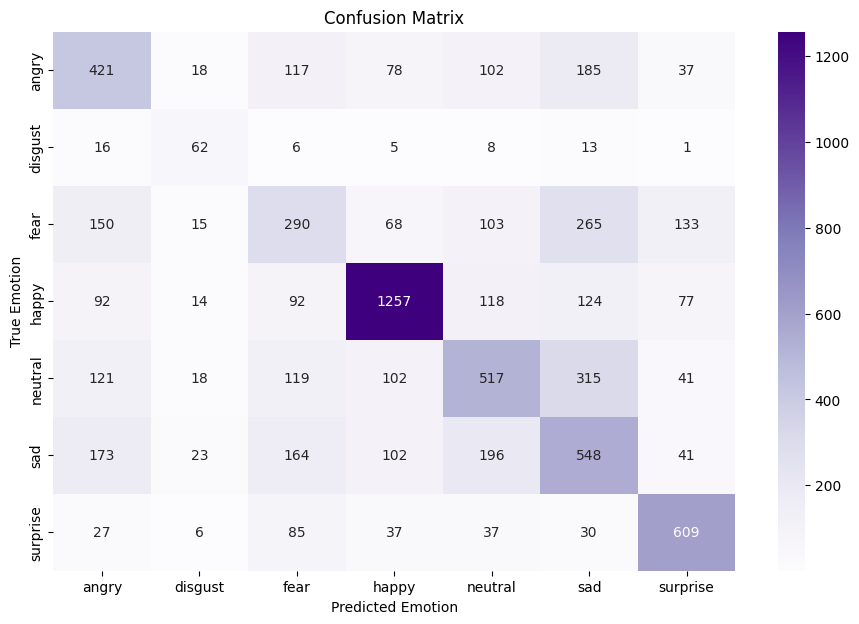

In [27]:
y_pred = model.predict(X_test)


cm = confusion_matrix(Y_test, y_pred.argmax(axis=1))


plt.figure(figsize=(11,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=Classes, yticklabels=Classes)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('seqfermodel3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = keras.models.load_model('seqfermodel3.h5')

Model Run with 2 Categories - Happy/Sad.

*   Training Data Accuracy: 95%+
*   Test Data Accuracy: 86%
*   Training Data Size: 12045
*   Test Data Size: 3021

Model Run with 3 Categories - Happy/Sad/Neutral.

*   Training Data Accuracy: 97%+
*   Test Data Accuracy: 69%
*   Training Data Size: 17010
*   Test Data Size: 4254

Model Run with 3 Categories - Happy/Sad/Angry.

*   Training Data Accuracy: 98%+
*   Test Data Accuracy: 72%
*   Training Data Size: 16040
*   Test Data Size: 3979

Model Run with 3 Categories that are lower in dataset size- Surprise/Fear/Disgust.

*   Training Data Accuracy: 98%
*   Test Data Accuracy: 79%
*   Training Data Size: 7704
*   Test Data Size: 1966

Model Run with 3 Categories that are similar in visual style (Sad/Fear/Angry)

*   Training Data Accuracy: 97%
*   Test Data Accuracy: 54%
*   Training Data Size: 12922
*   Test Data Size: 3229


Model Run with All Categories.

*   Training Data Accuracy: 93%+
*   Test Data Accuracy:  53.4%
*   Training Data Size: 28709
*   Test Data Size: 7178


Key notes:
* Additional training data DID improve model performance. When we switched from the modified dataset to the original, test data performance improved

* Pixel modification reduced performance. changing from 48x48 to 180x180 reduced the test data accuracy, as well as made the model take longer. The 180x180 model consumed around 64GB of memory. The 48x48 model consumed approximately 35GB, running on Google Colab TPU with Python3

* Keras Dropout Layer of 0.1 improved performance slightly, but only when applied to an earlier layer. Applying a Dropout to the final layer reduced accuracy, and we removed it. A Dropout layer can help reduce overfitting in some models, and we noticed a small improvement by adding it without negative impacts on performance or accuracy. A conservative probability of 10% yielded the best results.

* 30 epochs runs quite fast, but training data accuracy starts to reach 95%+ after 20 epochs. This may lead to overfitting in some cases, but 30 seemed to be a good balance between performance and time. The number of epoch iterations to reach 95% was not always consistent, ranging from 7 to 20 epochs. We may say that diminishing returns occurrs after 20 epochs per observations


* Image fidelity may play a role, where nuances in expression may not be detectible in a small image space of 48x48. Larger images require significantly more compute time on GPUs and it is always a balance

* Our examples show that reaching very high accuracy in training data (99%+) does not always correlate with high accuracy against testing data. Overfitting, Bias, or other ML/AI challenges can be observed. This is important to remember, and highlights the need for Testing and Validation datasets.

* Initial theory was that smaller datasets in categories such as Surprise, Fear and Disgust were a key driver in lower model performance in aggregate. However, on further research, these categories performed quite well (see Surprise/Fear/Disgust metric). We found the model performance is higher when a /smaller/ number of categories were included and is lower when including more categories.

* Theory: A small number of classifications (e.g. 3) can be performed with high accuracy. When a larger number of classifications are included, the overall model accuracy drops. It is easier to distinguish Happy/Sad vs a larger number of possibilieid, e.g. (Happy/Surprised/Surprised/Angry) within one model.

* Images with similar emotion visualizations (Sad, Angry, and Fearful all may have a frowning aspect) do have low test accuracy. 54% in this case. This points to the challenges in categorizing nuanced differences, while highlighting the relatively strong performance of categorizing emotions that are more visually distinct (Happy/Sad)

* The "Truthfulness" of the images should be considered, and data labeling biases may exist. What may be considered Neutral to some may look Angry to others.
